In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def create_random_directed_graph(num_nodes, edge_probability):
    graph = nx.gnp_random_graph(num_nodes, edge_probability, directed=True)
    return graph

def create_random_undirected_graph(num_nodes, edge_probability):
    graph = nx.gnp_random_graph(num_nodes, edge_probability, directed=False)
    return graph

def draw_graph(graph):
    nx.draw(graph, with_labels=True)
    plt.show()

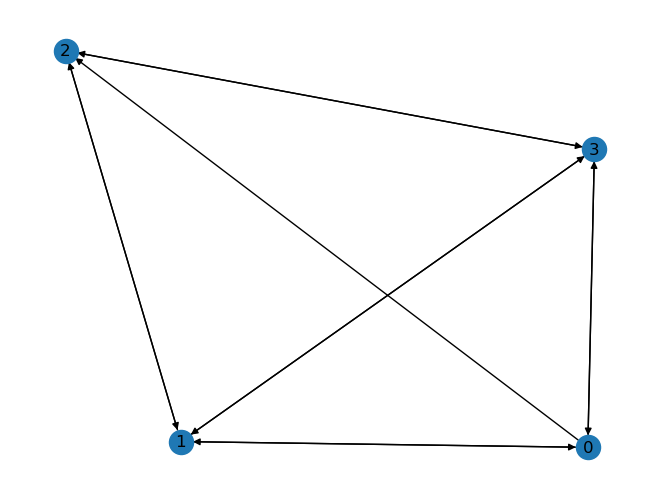

In [3]:
G = create_random_directed_graph(4, 0.7)
draw_graph(G)

In [7]:
def create_comparator_gate(num_qubits):
    a = QuantumRegister(num_qubits, name="a")
    b = QuantumRegister(num_qubits, name="b")
    output = QuantumRegister(1, name="output")

    qc = QuantumCircuit(a, b, output, name="Comparator")
    for i in range(num_qubits):
        qc.cx(a[i], b[i])
    qc.x(b)
    qc.mcx(b, output)
    qc.x(b)
    for i in range(num_qubits-1, -1, -1):
        qc.cx(a[i], b[i])
    
    return qc.to_gate(label="Comparator")

def create_plus_one_gate(num_qubits):
    qr = QuantumRegister(num_qubits, name="q")
    qc = QuantumCircuit(qr, name="PlusOne")

    for i in range(num_qubits-1, 0, -1):
        control_qubits = qr[:i]
        qc.mcx(control_qubits, qr[i])
    qc.x(qr[0])
    return qc.to_gate(label="PlusOne")

def create_minus_one_gate(num_qubits):
    plus_one = create_plus_one_gate(num_qubits)
    minus_one = plus_one.inverse()
    minus_one.label = "MinusOne"
    return minus_one


In [8]:
def initialize_circuit(G):
    num_nodes = G.number_of_nodes()
    qubits_per_node = int(np.ceil(np.log2(num_nodes)))
    aux_qubits = num_nodes * (num_nodes-1)/2

    main_qr = QuantumRegister(num_nodes * qubits_per_node, name="main")
    anc_qr = QuantumRegister(aux_qubits, name="anc")
    output_qr = QuantumRegister(1, name="output")
    classical_reg = ClassicalRegister(num_nodes * qubits_per_node, name="c")

    qc = QuantumCircuit(main_qr, anc_qr, output_qr, classical_reg)

    qc.h(main_qr)
    qc.x(anc_qr)

    return qc, main_qr, anc_qr, output_qr, classical_reg

def create_missing_edge_block(G, comparator, plus_one, minus_one, num_nodes, qubits_per_node):
    def get_missing_edges(G):
        complement = nx.complement(G.to_directed())
        missing_edges = list(complement.edges())
        double_edges = []
        for edge in missing_edges:
            if (edge[1], edge[0]) in missing_edges:
                missing_edges.remove((edge[1], edge[0]))
                missing_edges.remove(edge)
                double_edges.append(edge)
                print(f"Removed {edge}")
        return missing_edges, double_edges
    
    missing_edges, double_edges = get_missing_edges(G)
    aux_qubits = num_nodes * (num_nodes-1)/2

    main_qr = QuantumRegister(num_nodes * qubits_per_node, name="main")
    anc_qr = QuantumRegister(aux_qubits, name="anc")

    qc = QuantumCircuit(main_qr, anc_qr)

    counter = 0
    for edge in missing_edges:
        print(edge)
        target_1 = list(range(edge[0]*qubits_per_node, (edge[0]+1)*qubits_per_node))
        target_2 = list(range(edge[1]*qubits_per_node, (edge[1]+1)*qubits_per_node))
        qc.append(plus_one, target_1)
        qc.append(comparator, target_1 + target_2 + [anc_qr[counter]])
        qc.append(minus_one, target_1)
        counter += 1
    

    for edge in double_edges:
        print(edge)
        target_1 = list(range(edge[0]*qubits_per_node, (edge[0]+1)*qubits_per_node))
        target_2 = list(range(edge[1]*qubits_per_node, (edge[1]+1)*qubits_per_node))
        qc.append(plus_one, target_1)
        qc.append(comparator, target_1 + target_2 + [anc_qr[counter]])
        qc.append(minus_one, target_1)
        qc.append(minus_one, target_1)
        qc.append(comparator, target_1 + target_2 + [anc_qr[counter]])
        qc.append(plus_one, target_1)

        counter += 1

    missing_gate = qc.to_gate(label="MissingEdgeBlock")
    return missing_gate

def create_positional_exclusivity_block(G, comparator, num_nodes, qubits_per_node):
    aux_qubits = num_nodes * (num_nodes-1)/2

    main_qr = QuantumRegister(num_nodes * qubits_per_node, name="main")
    anc_qr = QuantumRegister(aux_qubits, name="anc")

    qc = QuantumCircuit(main_qr, anc_qr)

    counter = 0
    for i in range(num_nodes):
        target_1 = list(range(i*qubits_per_node, (i+1)*qubits_per_node))
        for j in range(i+1, num_nodes):
            target_2 = list(range(j*qubits_per_node, (j+1)*qubits_per_node))
            qc.append(comparator, target_1 + target_2 + [anc_qr[counter]])
            counter += 1

    exclusivity_gate = qc.to_gate(label="PositionalExclusivityBlock")
    return exclusivity_gate


In [9]:
def create_oracle(G):
    num_nodes = G.number_of_nodes()
    qubits_per_node = int(np.ceil(np.log2(num_nodes)))
    
    # Create the gates for the blocks
    comparator = create_comparator_gate(qubits_per_node)
    plus_one = create_plus_one_gate(qubits_per_node)
    minus_one = create_minus_one_gate(qubits_per_node)

    
    # Create the blocks
    missing_edge_block = create_missing_edge_block(G, comparator, plus_one, minus_one, num_nodes, qubits_per_node)
    positional_exclusivity_block = create_positional_exclusivity_block(G, comparator, num_nodes, qubits_per_node)

    main_qr = QuantumRegister(num_nodes * qubits_per_node, name="main")
    anc_qr = QuantumRegister(num_nodes * (num_nodes-1)/2, name="anc")
    output_qr = QuantumRegister(1, name="output")
    qc = QuantumCircuit(main_qr, anc_qr, output_qr)

    qc.append(missing_edge_block, main_qr[:] + anc_qr[:])
    qc.mcx(anc_qr, output_qr)
    qc.append(missing_edge_block, main_qr[:] + anc_qr[:])

    qc.append(positional_exclusivity_block, main_qr[:] + anc_qr[:])
    qc.h(output_qr)
    qc.mcx(anc_qr, output_qr)
    qc.h(output_qr)
    qc.append(positional_exclusivity_block, main_qr[:] + anc_qr[:])

    qc.append(missing_edge_block, main_qr[:] + anc_qr[:])
    qc.mcx(anc_qr, output_qr)
    qc.append(missing_edge_block, main_qr[:] + anc_qr[:])

    oracle = qc.to_gate(label="Oracle")
    return oracle

def create_grover_diffusion_operator(G):
    num_nodes = G.number_of_nodes()
    qubits_per_node = int(np.ceil(np.log2(num_nodes)))
                          
    main_qr = QuantumRegister(num_nodes * qubits_per_node, name="main")
    qc = QuantumCircuit(main_qr)
    qc.h(main_qr)
    qc.x(main_qr)
    qc.h(main_qr[-1])
    qc.mcx(main_qr[:-1], main_qr[-1])
    qc.h(main_qr[-1])
    qc.x(main_qr)
    qc.h(main_qr)

    diffusion_operator = qc.to_gate(label="DiffusionOperator")
    return diffusion_operator

def build_circuit(G, iterations=1):
    qc, main_qr, anc_qr, output_qr, classical_reg = initialize_circuit(G)
    oracle = create_oracle(G)
    diffuser = create_grover_diffusion_operator(G)

    for _ in range(iterations):
        qc.append(oracle, main_qr[:] + anc_qr[:] + output_qr[:])
        qc.append(diffuser, main_qr[:])
    qc.measure(main_qr, classical_reg)

    return qc


In [13]:
# Comparator image
a = QuantumRegister(2, name="a")
b = QuantumRegister(2, name="b")
output = QuantumRegister(1, name="output")
qc = QuantumCircuit(a, b, output)
qc.append(create_comparator_gate(2), a[:] + b[:] + output[:])

qc.decompose().draw(output="latex_source", filename="comparator.tex")

'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{a}_{0} :  } & \\lstick{{a}_{0} :  } & \\ctrl{2} & \\qw & \\qw & \\qw & \\qw & \\ctrl{2} & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{a}_{1} :  } & \\lstick{{a}_{1} :  } & \\qw & \\ctrl{2} & \\qw & \\qw & \\qw & \\qw & \\ctrl{2} & \\qw & \\qw\\\\\n\t \t\\nghost{{b}_{0} :  } & \\lstick{{b}_{0} :  } & \\targ & \\qw & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} & \\targ & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{b}_{1} :  } & \\lstick{{b}_{1} :  } & \\qw & \\targ & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} & \\qw & \\targ & \\qw & \\qw\\\\\n\t \t\\nghost{{output} :  } & \\lstick{{output} :  } & \\qw & \\qw & \\qw & \\targ & \\qw & \\qw & \\qw & \\qw & \\qw\\\\\n\\\\ }}\n\\end{document}'

In [26]:
# Extended comparator image
a = QuantumRegister(2, name="position_v1")
b = QuantumRegister(2, name="position_v2")
c = QuantumRegister(2, name="position_v3")
d = QuantumRegister(2, name="position_v4")
ancilla = QuantumRegister(6, name="ancilla")

qc = QuantumCircuit(a, b, c, d, ancilla)
qc.append(create_comparator_gate(2), a[:] + b[:] + [ancilla[0]])
qc.append(create_comparator_gate(2), a[:] + c[:] + [ancilla[1]])
qc.append(create_comparator_gate(2), a[:] + d[:] + [ancilla[2]])
qc.decompose().draw(output="latex_source", filename="comparator_extended.tex")


'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{position\\_v1}_{0} :  } & \\lstick{{position\\_v1}_{0} :  } & \\ctrl{2} & \\qw & \\qw & \\qw & \\qw & \\ctrl{2} & \\qw & \\ctrl{4} & \\qw & \\qw & \\qw & \\qw & \\ctrl{4} & \\qw & \\ctrl{6} & \\qw & \\qw & \\qw & \\qw & \\ctrl{6} & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{position\\_v1}_{1} :  } & \\lstick{{position\\_v1}_{1} :  } & \\qw & \\ctrl{2} & \\qw & \\qw & \\qw & \\qw & \\ctrl{2} & \\qw & \\ctrl{4} & \\qw & \\qw & \\qw & \\qw & \\ctrl{4} & \\qw & \\ctrl{6} & \\qw & \\qw & \\qw & \\qw & \\ctrl{6} & \\qw & \\qw\\\\\n\t \t\\nghost{{position\\_v2}_{0} :  } & \\lstick{{position\\_v2}_{0} :  } & \\targ & \\qw & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} & \\targ & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw

In [25]:
# Plus one image and Minus one image
a = QuantumRegister(2, name="a")
qc = QuantumCircuit(a)
qc.append(create_plus_one_gate(2), a[:])
qc.decompose().draw(output="latex_source", filename="plus_one.tex")

a = QuantumRegister(2, name="a")
qc = QuantumCircuit(a)
qc.append(create_minus_one_gate(2), a[:])
qc.decompose().draw(output="latex_source", filename="minus_one.tex")

'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{a}_{0} :  } & \\lstick{{a}_{0} :  } & \\gate{\\mathrm{X}} & \\ctrl{1} & \\qw & \\qw\\\\\n\t \t\\nghost{{a}_{1} :  } & \\lstick{{a}_{1} :  } & \\qw & \\targ & \\qw & \\qw\\\\\n\\\\ }}\n\\end{document}'

In [13]:
# Missing edge image
a = QuantumRegister(2, name="a")
b = QuantumRegister(2, name="b")
c = QuantumRegister(2, name="c")
d = QuantumRegister(2, name="d")
ancilla = QuantumRegister(3, name="ancilla")
qc = QuantumCircuit(a, b, c, d, ancilla)

# 1 a 3
qc.append(create_plus_one_gate(2), b[:])
qc.append(create_comparator_gate(2), b[:] + d[:] + [ancilla[0]])
qc.append(create_minus_one_gate(2), b[:])
qc.barrier()

# 3 a 1
qc.append(create_plus_one_gate(2), d[:])
qc.append(create_comparator_gate(2), d[:] + b[:] + [ancilla[1]])
qc.append(create_minus_one_gate(2), d[:])
qc.barrier()

# 3 a 0
qc.append(create_plus_one_gate(2), d[:])
qc.append(create_comparator_gate(2), d[:] + a[:] + [ancilla[2]])
qc.append(create_minus_one_gate(2), d[:])

qc.decompose().draw(output="latex_source", filename="missing_edge.tex")
# qc.decompose().draw(output="mpl")

'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{a}_{0} :  } & \\lstick{{a}_{0} :  } & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw \\barrier[0em]{10} & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw \\barrier[0em]{10} & \\qw & \\qw & \\qw & \\qw & \\targ & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} & \\targ & \\qw & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{a}_{1} :  } & \\lstick{{a}_{1} :  } & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\targ & \\qw & \\gate{\\mathrm{X}} & \\ctrl{9} & \\gate{\\mathrm{X}} & \\qw & \\targ & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{b}_{0} :  } & \\lstick{{b}_{0} :  } & \\ctrl{1} & \\gate{\\mathrm{X}} & \\ctrl{4} &

In [25]:
a = QuantumRegister(2, name="a")
b = QuantumRegister(2, name="b")
c = QuantumRegister(2, name="c")
d = QuantumRegister(2, name="d")
ancilla_pos = QuantumRegister(6, name="ancilla_pos")
ancilla_edge = QuantumRegister(6, name="ancilla_edge")

qc = QuantumCircuit(a, b, c, d, ancilla_pos, ancilla_edge)

# qc.h(a)
# qc.h(b)
# qc.h(c)
# qc.h(d)
# qc.x(ancilla_pos)
# qc.x(ancilla_edge)
pe_block = create_positional_exclusivity_block(G, create_comparator_gate(2), 4, 2)
me_block = create_missing_edge_block(G, create_comparator_gate(2), create_plus_one_gate(2), create_minus_one_gate(2), 4, 2)
qc.append(pe_block, a[:] + b[:] + c[:] + d[:] + ancilla_pos[:])
qc.append(me_block, a[:] + b[:] + c[:] + d[:] + ancilla_edge[:])

qc.cz(ancilla_pos[0], ancilla_edge[0])

qc.append(me_block, a[:] + b[:] + c[:] + d[:] + ancilla_edge[:])
qc.append(pe_block, a[:] + b[:] + c[:] + d[:] + ancilla_pos[:])

qc.draw(output="latex_source", filename="oracle.tex")

(2, 0)


'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{a}_{0} :  } & \\lstick{{a}_{0} :  } & \\multigate{13}{\\mathrm{PositionalExclusivityBlock}}_<<<{0} & \\multigate{19}{\\mathrm{MissingEdgeBlock}}_<<<{0} & \\qw & \\multigate{19}{\\mathrm{MissingEdgeBlock}}_<<<{0} & \\multigate{13}{\\mathrm{PositionalExclusivityBlock}}_<<<{0} & \\qw & \\qw\\\\\n\t \t\\nghost{{a}_{1} :  } & \\lstick{{a}_{1} :  } & \\ghost{\\mathrm{PositionalExclusivityBlock}}_<<<{1} & \\ghost{\\mathrm{MissingEdgeBlock}}_<<<{1} & \\qw & \\ghost{\\mathrm{MissingEdgeBlock}}_<<<{1} & \\ghost{\\mathrm{PositionalExclusivityBlock}}_<<<{1} & \\qw & \\qw\\\\\n\t \t\\nghost{{b}_{0} :  } & \\lstick{{b}_{0} :  } & \\ghost{\\mathrm{PositionalExclusivityBlock}}_<<<{2} & \\ghost{\\mathrm{MissingEdgeBlock}}_<<<{2} & \\qw & \\ghost{\\mathrm{MissingEdgeBlock}}_<<<{2} & \\ghost{\\mathrm{Position

In [38]:
# Controlled block

a = QuantumRegister(2, name="a")
b = QuantumRegister(2, name="b")

qc = QuantumCircuit(a, b)
plus = create_plus_one_gate(2).control(2)
qc.append(plus, a[:] + b[:])
qc.draw(output="latex_source", filename="controlled_plus_one.tex")

# Make a plus one control a minus one
a = QuantumRegister(2, name="a")
b = QuantumRegister(2, name="b")

qc = QuantumCircuit(a, b)
plus = create_plus_one_gate(2).control(2)
minus = create_minus_one_gate(2)
qc.append(plus, a[:] + b[:])
qc.append(minus, a[:])

qc.draw(output="latex_source", filename="controlled_plus_one_minus_one.tex")

'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{a}_{0} :  } & \\lstick{{a}_{0} :  } & \\ctrl{1} & \\multigate{1}{\\mathrm{MinusOne}}_<<<{0} & \\qw & \\qw\\\\\n\t \t\\nghost{{a}_{1} :  } & \\lstick{{a}_{1} :  } & \\ctrl{1} & \\ghost{\\mathrm{MinusOne}}_<<<{1} & \\qw & \\qw\\\\\n\t \t\\nghost{{b}_{0} :  } & \\lstick{{b}_{0} :  } & \\multigate{1}{\\mathrm{PlusOne}}_<<<{0} & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{b}_{1} :  } & \\lstick{{b}_{1} :  } & \\ghost{\\mathrm{PlusOne}}_<<<{1} & \\qw & \\qw & \\qw\\\\\n\\\\ }}\n\\end{document}'

In [11]:
# Grover diagram

main = QuantumRegister(1, name="main_register")
ancilla = QuantumRegister(1, name="ancilla")

qc = QuantumCircuit(main, ancilla)
qc.h(main)
qc.x(ancilla)

qc.append(create_minus_one_gate(2), main[:] + ancilla[:])
qc.h(main)
qc.draw("latex_source", filename="grover.tex")



'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{main\\_register} :  } & \\lstick{{main\\_register} :  } & \\gate{\\mathrm{H}} & \\multigate{1}{\\mathrm{MinusOne}}_<<<{0} & \\gate{\\mathrm{H}} & \\qw & \\qw\\\\\n\t \t\\nghost{{ancilla} :  } & \\lstick{{ancilla} :  } & \\gate{\\mathrm{X}} & \\ghost{\\mathrm{MinusOne}}_<<<{1} & \\qw & \\qw & \\qw\\\\\n\\\\ }}\n\\end{document}'